In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import issparse
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('text_preprocessing/final_dataset.csv')
df

,Sentiment,tweet_tokens_stemmed
0,positive,undang shanijkt hitamputih menang ssk jkt mjkt...
1,positive,selamat buka puasa moga amal ibadah terima allah
2,positive,trans hitam putih harga norwegia
3,positive,selamat hitamputih
4,positive,asiknya nonton hitam putih trans
...,...,...
395,negative,banget kesel debat pake emosi gin
396,negative,miskin miskin sekolah pungut liar
397,negative,emosi cepat tua nonton emosi bicara
398,negative,tampil kyk preman tau bkin kisruh usak


In [3]:
# Convert sentiment labels to binary
def convert_label_sentimen(label_sentimen):
    return 1 if label_sentimen == "positive" else 0

df['label_sentimen'] = df['Sentiment'].apply(convert_label_sentimen)
df.drop(df.columns[[0]], axis=1, inplace=True)
df


,tweet_tokens_stemmed,label_sentimen
0,undang shanijkt hitamputih menang ssk jkt mjkt...,1
1,selamat buka puasa moga amal ibadah terima allah,1
2,trans hitam putih harga norwegia,1
3,selamat hitamputih,1
4,asiknya nonton hitam putih trans,1
...,...,...
395,banget kesel debat pake emosi gin,0
396,miskin miskin sekolah pungut liar,0
397,emosi cepat tua nonton emosi bicara,0
398,tampil kyk preman tau bkin kisruh usak,0


In [4]:
X= df['tweet_tokens_stemmed'] 
y= df['label_sentimen']
#k-fold cross validation(spliting data)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


In [5]:
class NaiveBayes:
    def __init__(self, model_class):
        self.model_class = model_class
        self.clf = None
    
    def fit(self, X_train, y_train, selected_features):
        self.clf = self.model_class()
        if issparse(X_train):
            X_train = X_train.toarray()
        self.clf.fit(X_train[:, selected_features], y_train)
    
    def predict(self, X_test, selected_features):
        if self.clf is None:
            raise ValueError("Classifier not fitted. Please call 'fit' method first.")
        if issparse(X_test):
            X_test = X_test.toarray()
        return self.clf.predict(X_test[:, selected_features])

In [6]:
def evaluate_features(X_train, y_train, selected_features, classifier):
    clf = classifier
    cv_results = cross_val_score(clf.clf, X_train[:, selected_features], y_train, cv=kfold, scoring='accuracy')
    return cv_results.mean()

def pso_feature_selection(X_train, y_train, n_particles, inertia, global_weight, local_weight, model_class, tol=1e-5, patience=10):
    num_samples, num_features = X_train.shape
    bounds = [0, 1]
    
    num_particles = n_particles
    dimensions = num_features
    particles = np.random.rand(num_particles, dimensions)
    velocities = np.random.rand(num_particles, dimensions) * 0.1
    best_positions = particles.copy()
    best_scores = np.zeros(num_particles)

    global_best_position = np.zeros(dimensions)
    global_best_score = 0

    no_improvement_count = 0
    previous_global_best_score = 0

    while no_improvement_count < patience:
        for particle in range(num_particles):
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)
            velocities[particle] = (inertia * velocities[particle] +
                                    global_weight * r1 * (best_positions[particle] - particles[particle]) +
                                    local_weight * r2 * (global_best_position - particles[particle]))

            particles[particle] += velocities[particle]
            particles[particle] = np.clip(particles[particle], bounds[0], bounds[1])

            selected_features = particles[particle] > 0.5
            nb = NaiveBayes(model_class)
            nb.fit(X_train, y_train, selected_features)
            accuracy = evaluate_features(X_train, y_train, selected_features, nb)

            if accuracy > best_scores[particle]:
                best_scores[particle] = accuracy
                best_positions[particle] = particles[particle].copy()

            if accuracy > global_best_score:
                global_best_score = accuracy
                global_best_position = particles[particle].copy()

        if abs(global_best_score - previous_global_best_score) < tol:
            no_improvement_count += 1
        else:
            no_improvement_count = 0
        
        previous_global_best_score = global_best_score

    return global_best_position > 0.5

Fold 1 - MultinomialNB:
  Accuracy Test: 0.8000
  Precision Test: 0.8333
  Recall Test: 0.7500
  Accuracy Train: 0.9583
  Precision Train: 0.9609
  Recall Train: 0.9556
Fold 2 - MultinomialNB:
  Accuracy Test: 0.7500
  Precision Test: 0.7273
  Recall Test: 0.8000
  Accuracy Train: 0.9611
  Precision Train: 0.9368
  Recall Train: 0.9889
Fold 3 - MultinomialNB:
  Accuracy Test: 0.7750
  Precision Test: 0.7619
  Recall Test: 0.8000
  Accuracy Train: 0.9750
  Precision Train: 0.9622
  Recall Train: 0.9889
Fold 4 - MultinomialNB:
  Accuracy Test: 0.6750
  Precision Test: 0.6296
  Recall Test: 0.8500
  Accuracy Train: 0.9833
  Precision Train: 0.9780
  Recall Train: 0.9889
Fold 5 - MultinomialNB:
  Accuracy Test: 0.9500
  Precision Test: 0.9500
  Recall Test: 0.9500
  Accuracy Train: 0.9833
  Precision Train: 0.9728
  Recall Train: 0.9944
Fold 6 - MultinomialNB:
  Accuracy Test: 0.7500
  Precision Test: 0.7500
  Recall Test: 0.7500
  Accuracy Train: 0.9639
  Precision Train: 0.9563
  Recall 

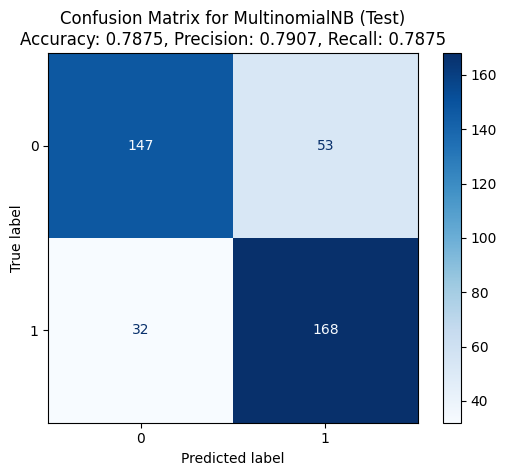

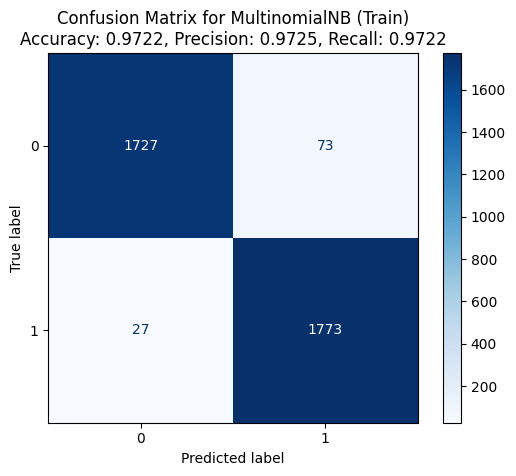

Fold 1 - BernoulliNB:
  Accuracy Test: 0.8500
  Precision Test: 0.8500
  Recall Test: 0.8500
  Accuracy Train: 0.9500
  Precision Train: 0.9451
  Recall Train: 0.9556
Fold 2 - BernoulliNB:
  Accuracy Test: 0.7000
  Precision Test: 0.6333
  Recall Test: 0.9500
  Accuracy Train: 0.9639
  Precision Train: 0.9418
  Recall Train: 0.9889
Fold 3 - BernoulliNB:
  Accuracy Test: 0.8000
  Precision Test: 0.8333
  Recall Test: 0.7500
  Accuracy Train: 0.9667
  Precision Train: 0.9565
  Recall Train: 0.9778
Fold 4 - BernoulliNB:
  Accuracy Test: 0.6750
  Precision Test: 0.6296
  Recall Test: 0.8500
  Accuracy Train: 0.9694
  Precision Train: 0.9669
  Recall Train: 0.9722
Fold 5 - BernoulliNB:
  Accuracy Test: 0.9500
  Precision Test: 0.9500
  Recall Test: 0.9500
  Accuracy Train: 0.9583
  Precision Train: 0.9459
  Recall Train: 0.9722
Fold 6 - BernoulliNB:
  Accuracy Test: 0.8500
  Precision Test: 0.9375
  Recall Test: 0.7500
  Accuracy Train: 0.9639
  Precision Train: 0.9563
  Recall Train: 0.972

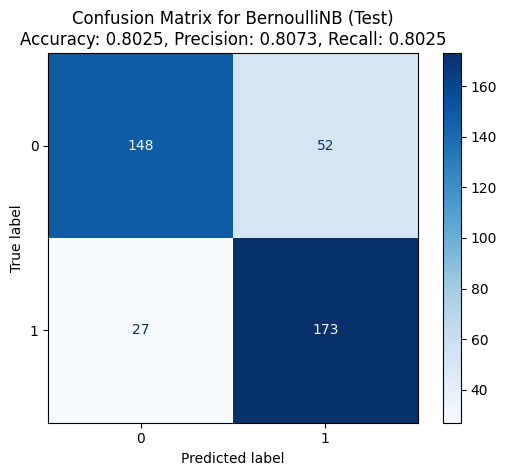

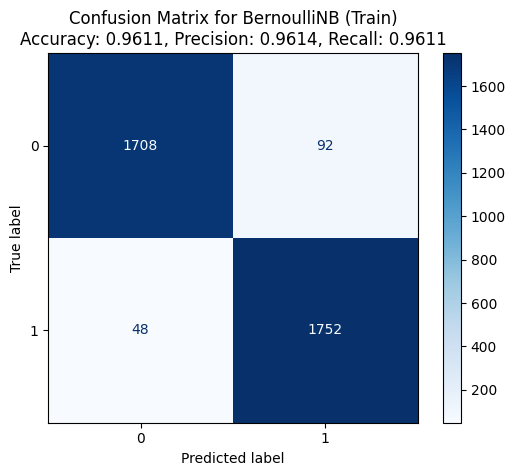

Fold 1 - GaussianNB:
  Accuracy Test: 0.8250
  Precision Test: 0.7600
  Recall Test: 0.9500
  Accuracy Train: 0.9889
  Precision Train: 0.9783
  Recall Train: 1.0000
Fold 2 - GaussianNB:
  Accuracy Test: 0.7500
  Precision Test: 0.7083
  Recall Test: 0.8500
  Accuracy Train: 0.9889
  Precision Train: 0.9783
  Recall Train: 1.0000
Fold 3 - GaussianNB:
  Accuracy Test: 0.8250
  Precision Test: 0.7826
  Recall Test: 0.9000
  Accuracy Train: 0.9778
  Precision Train: 0.9574
  Recall Train: 1.0000
Fold 4 - GaussianNB:
  Accuracy Test: 0.6750
  Precision Test: 0.6296
  Recall Test: 0.8500
  Accuracy Train: 0.9889
  Precision Train: 0.9783
  Recall Train: 1.0000
Fold 5 - GaussianNB:
  Accuracy Test: 0.8750
  Precision Test: 0.8571
  Recall Test: 0.9000
  Accuracy Train: 0.9750
  Precision Train: 0.9524
  Recall Train: 1.0000
Fold 6 - GaussianNB:
  Accuracy Test: 0.7000
  Precision Test: 0.6538
  Recall Test: 0.8500
  Accuracy Train: 0.9750
  Precision Train: 0.9524
  Recall Train: 1.0000
Fold

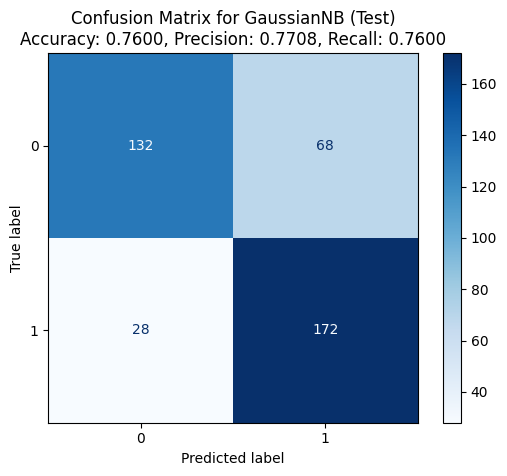

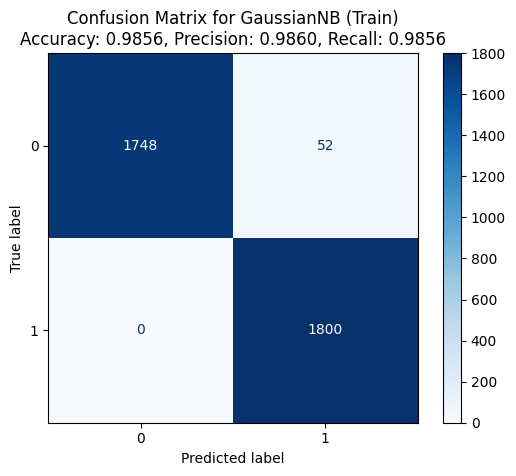


Overall Results:
        Model  Average AccuracyTest  Average AccuracyTrain  Average PrecisionTest  Average PrecisionTrain  Average RecallTest  Average RecallTrain
MultinomialNB                0.7875               0.972222               0.765903                0.960581               0.840             0.985000
  BernoulliNB                0.8025               0.961111               0.786404                0.950305               0.865             0.973333
   GaussianNB                0.7600               0.985556               0.722021                0.972073               0.860             1.000000


In [7]:
# Define parameters for PSO optimization
n_particles = 80
inertia = 0.9
global_weight = 0.4
local_weight = 0.7

results = []

for model_class in [MultinomialNB, BernoulliNB, GaussianNB]:
    accuracy_scoresTest = []
    accuracy_scoresTrain = []
    precision_scoresTest = []
    precision_scoresTrain = []
    recall_scoresTest = []
    recall_scoresTrain = []
    all_y_test = []
    all_y_predTest = []
    all_y_train = []
    all_y_predTrain = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        tfidf_model = TfidfVectorizer(smooth_idf=False)
        X_train_tfidf = tfidf_model.fit_transform(X_train)
        X_test_tfidf = tfidf_model.transform(X_test)

        X_train_dense = X_train_tfidf.toarray()
        selected_features = pso_feature_selection(X_train_dense, y_train, n_particles, inertia, global_weight, local_weight, model_class)

        if not np.any(selected_features):
            selected_features[0] = True

        nb = NaiveBayes(model_class)
        nb.fit(X_train_tfidf, y_train, selected_features)

        y_predTest = nb.predict(X_test_tfidf.toarray(), selected_features)
        y_predTrain = nb.predict(X_train_tfidf.toarray(), selected_features)

        accuracy_scoresTest.append(accuracy_score(y_test, y_predTest))
        precision_scoresTest.append(precision_score(y_test, y_predTest))
        recall_scoresTest.append(recall_score(y_test, y_predTest))
        accuracy_scoresTrain.append(accuracy_score(y_train, y_predTrain))
        precision_scoresTrain.append(precision_score(y_train, y_predTrain))
        recall_scoresTrain.append(recall_score(y_train, y_predTrain))

        all_y_test.extend(y_test)
        all_y_predTest.extend(y_predTest)
        all_y_train.extend(y_train)
        all_y_predTrain.extend(y_predTrain)

        # Print metrics for current fold
        print(f"Fold {fold} - {model_class.__name__}:")
        print(f"  Accuracy Test: {accuracy_score(y_test, y_predTest):.4f}")
        print(f"  Precision Test: {precision_score(y_test, y_predTest):.4f}")
        print(f"  Recall Test: {recall_score(y_test, y_predTest):.4f}")
        print(f"  Accuracy Train: {accuracy_score(y_train, y_predTrain):.4f}")
        print(f"  Precision Train: {precision_score(y_train, y_predTrain):.4f}")
        print(f"  Recall Train: {recall_score(y_train, y_predTrain):.4f}")

    fold_results = {
        "Model": model_class.__name__,
        "Average AccuracyTest": np.mean(accuracy_scoresTest),
        "Average AccuracyTrain": np.mean(accuracy_scoresTrain),
        "Average PrecisionTest": np.mean(precision_scoresTest),
        "Average PrecisionTrain": np.mean(precision_scoresTrain),
        "Average RecallTest": np.mean(recall_scoresTest),
        "Average RecallTrain": np.mean(recall_scoresTrain)
    }

    results.append(fold_results)

    # Display confusion matrix for combined folds
    def plot_confusion_matrix(y_true, y_pred, model_name, dataset_type):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        plt.title(f'Confusion Matrix for {model_name} ({dataset_type})\n'
                  f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
        plt.show()

    plot_confusion_matrix(all_y_test, all_y_predTest, model_class.__name__, 'Test')
    plot_confusion_matrix(all_y_train, all_y_predTrain, model_class.__name__, 'Train')

results_df = pd.DataFrame(results)
print("\nOverall Results:")
print(results_df.to_string(index=False))

EVALUASI TRAIN

In [ ]:

n_particles = 20
inertia = 0.8
global_weight = 1
local_weight = 0.9

results = []

for model_class in [MultinomialNB, BernoulliNB, GaussianNB]:
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    selected_features_list = []

    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        tfidf_model = TfidfVectorizer(smooth_idf=False)
        X_train_tfidf = tfidf_model.fit_transform(X_train)
        X_test_tfidf = tfidf_model.transform(X_test)

        X_train_dense = X_train_tfidf.toarray()
        selected_features = pso_feature_selection(X_train_dense, y_train, n_particles, inertia, global_weight, local_weight, model_class)
        selected_features_list.append(selected_features)

        if not np.any(selected_features):
            selected_features[0] = True

        nb = NaiveBayes(model_class)
        nb.fit(X_train_tfidf, y_train, selected_features)
        y_pred = nb.predict(X_test_tfidf.toarray(), selected_features)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))

    fold_results = {
        "Model": model_class.__name__,
        "Average Accuracy": np.mean(accuracy_scores),
        "Average Precision": np.mean(precision_scores),
        "Average Recall": np.mean(recall_scores),
        "Selected Features": selected_features_list
    }

    results.append(fold_results)

results_df = pd.DataFrame(results)

# Convert the list of arrays of selected features to a more readable format
for i in range(len(results_df)):
    model_name = results_df.iloc[i]["Model"]
    features = results_df.iloc[i]["Selected Features"]
    print(f"Model: {model_name}")
    for fold, selected in enumerate(features, start=1):
        print(f" Fold {fold}: {np.where(selected)[0]}")

# Drop the selected features from the final dataframe for clean display
results_df = results_df.drop(columns=["Selected Features"])
print("\nFinal Results:\n", results_df.to_string(index=False))


Model: MultinomialNB
 Fold 1: [   0    3    4    5    8   11   12   13   14   18   20   22   23   24
   28   29   30   31   35   36   39   41   42   43   44   47   48   50
   52   53   55   56   58   61   62   66   67   69   71   72   75   80
   87   90   91   93   94   95   97  100  104  105  106  108  113  116
  118  119  123  128  129  131  132  133  135  136  137  138  139  143
  146  147  149  151  154  155  156  157  159  160  162  163  166  167
  168  170  176  177  178  179  182  183  186  187  188  189  190  191
  193  194  196  197  198  200  202  205  206  207  208  209  210  211
  213  214  216  218  219  221  222  226  232  234  235  236  237  238
  242  243  244  245  246  247  248  249  254  255  256  258  259  260
  261  262  263  264  265  267  268  270  271  272  273  274  275  276
  278  282  283  284  285  286  288  289  295  297  299  302  303  304
  307  309  310  313  315  317  318  319  320  321  325  326  327  328
  331  335  336  337  339  343  344  348  354  